In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Libraries

In [ ]:
# Library to support working with data
import numpy as np
import pandas as pd

# Graphing support library
import matplotlib.pyplot as plt

# Data Normalization Support Library
from sklearn.preprocessing import MinMaxScaler

# Library to support building Temporal Convolutional Attention Networks models
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Layer, RepeatVector, concatenate, Reshape, Input, Concatenate, Permute, Multiply, Add, Activation

# Performance metrics calculation support library
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

# Parameter optimization support library
import optuna

# Support library to ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Support library to load models and data
from keras.utils import custom_object_scope
from tensorflow.keras.models import load_model

## Data preprocessing

### Read data

In [ ]:
# Load data
df = pd.read_csv('CTLT.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,30.860001,31.260000,30.240000,30.910000,30.910000,1201700
1,2019-01-03,30.660000,30.660000,29.290001,29.840000,29.840000,1149900
2,2019-01-04,30.049999,31.360001,29.940001,31.080000,31.080000,3530400
3,2019-01-07,31.020000,32.180000,30.850000,32.000000,32.000000,1063400
4,2019-01-08,32.340000,33.060001,32.150002,32.790001,32.790001,1391000
...,...,...,...,...,...,...,...
1079,2023-04-17,46.009998,49.860001,42.529999,45.430000,45.430000,14629300
1080,2023-04-18,45.200001,45.375000,41.509998,42.080002,42.080002,10057000
1081,2023-04-19,41.419998,43.669998,41.330002,43.070000,43.070000,6744900
1082,2023-04-20,42.660000,44.410000,42.259998,44.400002,44.400002,3464300


### Reset index

In [ ]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

In [ ]:
# Select column 'Close'
df_Close = df[['Close']]
df_Close = df_Close.reset_index(drop=True)

### Data normalization

In [ ]:
# Min-max normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Close))

### Data splitting

In [ ]:
# Split the data into train, validation, and test dataset in a ratio of 7:1:2
train_size = int(len(data_scaled) * 0.7)
val_size = int(len(data_scaled) * 0.1)
test_size = len(data_scaled) - train_size - val_size

train_data = data_scaled[: train_size]
val_data = data_scaled[train_size : train_size + val_size]
test_data = data_scaled[train_size + val_size :]

## Model training and testing

In [ ]:
# Generating data using the window sliding method
def create_dataset(data, window_size):
    windows, targets = [], []
    for i in range(len(data) - window_size - 1):
        windows.append(data[i : (i + window_size), 0])
        targets.append(data[i + window_size, 0])
    return np.array(windows), np.array(targets)

### Building TCANs model

In [ ]:
# Constructing sparse attention layer
class AttentionLayer(Layer):
    def __init__(self, attention_dim):
        super(AttentionLayer, self).__init__()
        self.attention_dim = attention_dim

    def build(self, input_shape):
        self.W1 = Dense(units=self.attention_dim, activation='tanh')
        self.W2 = Dense(units=1, activation='linear')
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        score = self.W2(self.W1(x))
        score = Flatten()(score)
        score = Activation('softmax')(score)
        score = RepeatVector(x.shape[-1])(score)
        score = Permute([2, 1])(score)
        return Multiply()([x, score])

    def compute_output_shape(self, input_shape):
        return input_shape

In [ ]:
# Build TCAN model
def build_tcan(window_size, input_dim=1, tcn_filters=64, tcn_kernel_size=2, dropout_rate=0.2, attention_dim=16):
    inputs = Input(shape=(window_size, input_dim))
    x = inputs
    x = Conv1D(filters=tcn_filters, kernel_size=tcn_kernel_size, padding='same', activation='relu')(x)
    x = SpatialDropout1D(rate=dropout_rate)(x)
    x = Conv1D(filters=tcn_filters, kernel_size=tcn_kernel_size, padding='same', activation='relu')(x)
    x = SpatialDropout1D(rate=dropout_rate)(x)

    # Additive Attention
    att = AttentionLayer(attention_dim)(x)
    max_pool_att = GlobalMaxPooling1D()(att)
    max_pool_x = GlobalMaxPooling1D()(x)
    x = concatenate([max_pool_att, max_pool_x])

    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mean_absolute_error', optimizer=optimizer)

    return model

### Learning process with combined parameter optimization

In [ ]:
# Initialization of optimization parameters
best_mse = float('inf')
best_model = None
best_window_size = None
best_train_windows = None
best_train_targets = None
best_test_windows = None
best_test_targets = None
best_val_windows = None
best_val_targets = None
best_y_pred = None
best_mape = np.inf
best_rmse = np.inf
best_msle = np.inf

In [ ]:
# Define the objective function for Optuna optimization
def objective(trial):
  global best_mse, best_model, best_window_size, best_train_windows
  global best_train_targets, best_test_windows, best_test_targets, best_val_windows
  global best_val_targets, best_y_pred, best_mape, best_rmse, best_msle

  # Define the search space for hyperparameters
  window_size = trial.suggest_int("window_size", 10, 100)
  tcn_filters = trial.suggest_int("tcn_filters", 32, 128)
  tcn_kernel_size = trial.suggest_int("tcn_kernel_size", 2, 5)
  dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
  attention_dim = trial.suggest_int("attention_dim", 8, 32)

  # Build the TCAN model with the suggested hyperparameters
  model = build_tcan(window_size, 
                     tcn_filters = tcn_filters, 
                     tcn_kernel_size = tcn_kernel_size,
                     dropout_rate = dropout_rate, 
                     attention_dim = attention_dim)

  train_windows, train_targets = create_dataset(train_data, window_size)
  test_windows, test_targets = create_dataset(test_data, window_size)
  val_windows, val_targets = create_dataset(val_data, window_size)

  # Train the model
  early_stop = EarlyStopping(monitor='val_loss', patience=5)
  model.fit(train_windows, train_targets, 
            epochs=50, batch_size=32,
            validation_data=(val_windows, val_targets), 
            shuffle=False, callbacks=[early_stop], verbose=0)

  # Evaluate the model
  y_pred = model.predict(test_windows)
  mse = mean_squared_error(test_targets, y_pred)
  rmse = np.sqrt(mse)
  mape = mean_absolute_percentage_error(test_targets, y_pred)
  msle = mean_squared_log_error(test_targets, y_pred)

  # Save the best model and related information
  if mse < best_mse or best_mse is None:
    best_model = model
    best_window_size = window_size
    best_y_pred = y_pred
    best_train_windows = train_windows
    best_train_targets = train_targets
    best_test_windows = test_windows
    best_test_targets = test_targets
    best_val_windows = val_windows
    best_val_targets = val_targets
    best_rmse = rmse
    best_mape = mape
    best_msle = msle
    best_mse = mse

  return mse

In [ ]:
# Define the search space for the hyperparameters
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2023-06-09 07:08:44,743] A new study created in memory with name: no-name-6663f32c-418a-47cd-bfa0-7384d1266466


2/2 [==============================] - 0s 4ms/step


[I 2023-06-09 07:08:56,756] Trial 0 finished with value: 0.003155300031849889 and parameters: {'window_size': 75, 'tcn_filters': 79, 'tcn_kernel_size': 2, 'dropout_rate': 0.3667741353660299, 'attention_dim': 16}. Best is trial 0 with value: 0.003155300031849889.


3/3 [==============================] - 0s 3ms/step


[I 2023-06-09 07:09:02,288] Trial 1 finished with value: 0.0020243019783343927 and parameters: {'window_size': 38, 'tcn_filters': 67, 'tcn_kernel_size': 2, 'dropout_rate': 0.10163983340229327, 'attention_dim': 20}. Best is trial 1 with value: 0.0020243019783343927.


2/2 [==============================] - 0s 7ms/step


[I 2023-06-09 07:09:10,681] Trial 2 finished with value: 0.006648442311756734 and parameters: {'window_size': 47, 'tcn_filters': 125, 'tcn_kernel_size': 3, 'dropout_rate': 0.15005870117423037, 'attention_dim': 29}. Best is trial 1 with value: 0.0020243019783343927.


2/2 [==============================] - 0s 6ms/step


[I 2023-06-09 07:09:22,081] Trial 3 finished with value: 0.004159805542145793 and parameters: {'window_size': 64, 'tcn_filters': 57, 'tcn_kernel_size': 5, 'dropout_rate': 0.42092301663861076, 'attention_dim': 31}. Best is trial 1 with value: 0.0020243019783343927.


3/3 [==============================] - 0s 3ms/step


[I 2023-06-09 07:09:25,829] Trial 4 finished with value: 0.00489070303265755 and parameters: {'window_size': 17, 'tcn_filters': 50, 'tcn_kernel_size': 4, 'dropout_rate': 0.14324898699323707, 'attention_dim': 30}. Best is trial 1 with value: 0.0020243019783343927.


2/2 [==============================] - 0s 7ms/step


[I 2023-06-09 07:09:35,275] Trial 5 finished with value: 0.003388569677752536 and parameters: {'window_size': 54, 'tcn_filters': 41, 'tcn_kernel_size': 3, 'dropout_rate': 0.2822776819593994, 'attention_dim': 29}. Best is trial 1 with value: 0.0020243019783343927.


1/1 [==============================] - 0s 160ms/step


[I 2023-06-09 07:09:41,626] Trial 6 finished with value: 0.011450993195321666 and parameters: {'window_size': 97, 'tcn_filters': 54, 'tcn_kernel_size': 2, 'dropout_rate': 0.4694945597832417, 'attention_dim': 14}. Best is trial 1 with value: 0.0020243019783343927.


1/1 [==============================] - 0s 113ms/step


[I 2023-06-09 07:09:49,149] Trial 7 finished with value: 0.014356442515362224 and parameters: {'window_size': 96, 'tcn_filters': 103, 'tcn_kernel_size': 4, 'dropout_rate': 0.4551274369311352, 'attention_dim': 29}. Best is trial 1 with value: 0.0020243019783343927.


1/1 [==============================] - 0s 103ms/step


[I 2023-06-09 07:10:00,561] Trial 8 finished with value: 0.008326993667596294 and parameters: {'window_size': 90, 'tcn_filters': 54, 'tcn_kernel_size': 3, 'dropout_rate': 0.28737863408115305, 'attention_dim': 30}. Best is trial 1 with value: 0.0020243019783343927.


3/3 [==============================] - 0s 5ms/step


[I 2023-06-09 07:10:12,276] Trial 9 finished with value: 0.005850019070376827 and parameters: {'window_size': 34, 'tcn_filters': 121, 'tcn_kernel_size': 4, 'dropout_rate': 0.1995138412654418, 'attention_dim': 16}. Best is trial 1 with value: 0.0020243019783343927.


3/3 [==============================] - 0s 3ms/step


[I 2023-06-09 07:10:16,011] Trial 10 finished with value: 0.0020864925720657083 and parameters: {'window_size': 15, 'tcn_filters': 80, 'tcn_kernel_size': 2, 'dropout_rate': 0.11120263589369607, 'attention_dim': 8}. Best is trial 1 with value: 0.0020243019783343927.


3/3 [==============================] - 0s 4ms/step


[I 2023-06-09 07:10:22,289] Trial 11 finished with value: 0.002696408679992762 and parameters: {'window_size': 13, 'tcn_filters': 83, 'tcn_kernel_size': 2, 'dropout_rate': 0.10936564303713729, 'attention_dim': 8}. Best is trial 1 with value: 0.0020243019783343927.


3/3 [==============================] - 0s 4ms/step


[I 2023-06-09 07:10:28,616] Trial 12 finished with value: 0.0028636810988185357 and parameters: {'window_size': 33, 'tcn_filters': 78, 'tcn_kernel_size': 2, 'dropout_rate': 0.21007101952536789, 'attention_dim': 23}. Best is trial 1 with value: 0.0020243019783343927.


3/3 [==============================] - 0s 4ms/step


[I 2023-06-09 07:10:35,400] Trial 13 finished with value: 0.004939729545762395 and parameters: {'window_size': 28, 'tcn_filters': 95, 'tcn_kernel_size': 2, 'dropout_rate': 0.10162656736107427, 'attention_dim': 9}. Best is trial 1 with value: 0.0020243019783343927.


3/3 [==============================] - 0s 3ms/step


[I 2023-06-09 07:10:42,098] Trial 14 finished with value: 0.00377191569331993 and parameters: {'window_size': 44, 'tcn_filters': 65, 'tcn_kernel_size': 3, 'dropout_rate': 0.2048450497062826, 'attention_dim': 23}. Best is trial 1 with value: 0.0020243019783343927.


3/3 [==============================] - 0s 3ms/step


[I 2023-06-09 07:10:45,721] Trial 15 finished with value: 0.006358179405031569 and parameters: {'window_size': 22, 'tcn_filters': 69, 'tcn_kernel_size': 5, 'dropout_rate': 0.10172608963399374, 'attention_dim': 12}. Best is trial 1 with value: 0.0020243019783343927.


3/3 [==============================] - 0s 3ms/step


[I 2023-06-09 07:10:49,652] Trial 16 finished with value: 0.002227554444783824 and parameters: {'window_size': 41, 'tcn_filters': 33, 'tcn_kernel_size': 2, 'dropout_rate': 0.17537383652703092, 'attention_dim': 19}. Best is trial 1 with value: 0.0020243019783343927.


4/4 [==============================] - 0s 3ms/step


[I 2023-06-09 07:10:52,726] Trial 17 finished with value: 0.0029466507044008444 and parameters: {'window_size': 10, 'tcn_filters': 97, 'tcn_kernel_size': 3, 'dropout_rate': 0.2513946566454944, 'attention_dim': 25}. Best is trial 1 with value: 0.0020243019783343927.


3/3 [==============================] - 0s 4ms/step


[I 2023-06-09 07:10:59,097] Trial 18 finished with value: 0.0013925877757686273 and parameters: {'window_size': 26, 'tcn_filters': 110, 'tcn_kernel_size': 2, 'dropout_rate': 0.15478791884481155, 'attention_dim': 19}. Best is trial 18 with value: 0.0013925877757686273.


2/2 [==============================] - 0s 7ms/step


[I 2023-06-09 07:11:07,547] Trial 19 finished with value: 0.0024130698648179706 and parameters: {'window_size': 67, 'tcn_filters': 110, 'tcn_kernel_size': 3, 'dropout_rate': 0.23532665426306157, 'attention_dim': 20}. Best is trial 18 with value: 0.0013925877757686273.


2/2 [==============================] - 0s 7ms/step


[I 2023-06-09 07:11:19,001] Trial 20 finished with value: 0.008088255941910536 and parameters: {'window_size': 54, 'tcn_filters': 112, 'tcn_kernel_size': 2, 'dropout_rate': 0.171320585120251, 'attention_dim': 18}. Best is trial 18 with value: 0.0013925877757686273.


3/3 [==============================] - 0s 4ms/step


[I 2023-06-09 07:11:23,341] Trial 21 finished with value: 0.0027709985273376694 and parameters: {'window_size': 24, 'tcn_filters': 88, 'tcn_kernel_size': 2, 'dropout_rate': 0.13355348410133272, 'attention_dim': 12}. Best is trial 18 with value: 0.0013925877757686273.


3/3 [==============================] - 0s 4ms/step


[I 2023-06-09 07:11:30,334] Trial 22 finished with value: 0.0018083944481992263 and parameters: {'window_size': 35, 'tcn_filters': 69, 'tcn_kernel_size': 2, 'dropout_rate': 0.1428412878739067, 'attention_dim': 23}. Best is trial 18 with value: 0.0013925877757686273.


3/3 [==============================] - 0s 4ms/step


[I 2023-06-09 07:11:41,784] Trial 23 finished with value: 0.0030554089805884766 and parameters: {'window_size': 36, 'tcn_filters': 67, 'tcn_kernel_size': 2, 'dropout_rate': 0.16160580810903916, 'attention_dim': 23}. Best is trial 18 with value: 0.0013925877757686273.


3/3 [==============================] - 0s 3ms/step


[I 2023-06-09 07:11:48,126] Trial 24 finished with value: 0.0019315716875322156 and parameters: {'window_size': 28, 'tcn_filters': 71, 'tcn_kernel_size': 3, 'dropout_rate': 0.1434124584689998, 'attention_dim': 26}. Best is trial 18 with value: 0.0013925877757686273.


3/3 [==============================] - 0s 5ms/step


[I 2023-06-09 07:11:52,355] Trial 25 finished with value: 0.0027650122842689294 and parameters: {'window_size': 28, 'tcn_filters': 89, 'tcn_kernel_size': 3, 'dropout_rate': 0.18986222148098197, 'attention_dim': 26}. Best is trial 18 with value: 0.0013925877757686273.


3/3 [==============================] - 0s 4ms/step


[I 2023-06-09 07:11:56,139] Trial 26 finished with value: 0.003601925977149921 and parameters: {'window_size': 22, 'tcn_filters': 72, 'tcn_kernel_size': 4, 'dropout_rate': 0.14292416928818336, 'attention_dim': 25}. Best is trial 18 with value: 0.0013925877757686273.


2/2 [==============================] - 0s 7ms/step


[I 2023-06-09 07:12:02,536] Trial 27 finished with value: 0.004052651450443388 and parameters: {'window_size': 49, 'tcn_filters': 61, 'tcn_kernel_size': 3, 'dropout_rate': 0.24866355513653038, 'attention_dim': 27}. Best is trial 18 with value: 0.0013925877757686273.


3/3 [==============================] - 0s 4ms/step


[I 2023-06-09 07:12:07,250] Trial 28 finished with value: 0.001559011318731072 and parameters: {'window_size': 27, 'tcn_filters': 46, 'tcn_kernel_size': 3, 'dropout_rate': 0.17255934986502228, 'attention_dim': 22}. Best is trial 18 with value: 0.0013925877757686273.


2/2 [==============================] - 0s 6ms/step


[I 2023-06-09 07:12:13,637] Trial 29 finished with value: 0.0026640461279384083 and parameters: {'window_size': 62, 'tcn_filters': 46, 'tcn_kernel_size': 2, 'dropout_rate': 0.340255562503626, 'attention_dim': 21}. Best is trial 18 with value: 0.0013925877757686273.


1/1 [==============================] - 0s 107ms/step


[I 2023-06-09 07:12:20,369] Trial 30 finished with value: 0.007774429993366497 and parameters: {'window_size': 81, 'tcn_filters': 32, 'tcn_kernel_size': 4, 'dropout_rate': 0.22428450202493655, 'attention_dim': 16}. Best is trial 18 with value: 0.0013925877757686273.


3/3 [==============================] - 0s 5ms/step


[I 2023-06-09 07:12:26,815] Trial 31 finished with value: 0.002543538654770381 and parameters: {'window_size': 29, 'tcn_filters': 74, 'tcn_kernel_size': 3, 'dropout_rate': 0.1854658131264659, 'attention_dim': 22}. Best is trial 18 with value: 0.0013925877757686273.


3/3 [==============================] - 0s 4ms/step


[I 2023-06-09 07:12:30,910] Trial 32 finished with value: 0.002089862969761314 and parameters: {'window_size': 18, 'tcn_filters': 40, 'tcn_kernel_size': 3, 'dropout_rate': 0.16073339896440522, 'attention_dim': 18}. Best is trial 18 with value: 0.0013925877757686273.


3/3 [==============================] - 0s 3ms/step


[I 2023-06-09 07:12:38,419] Trial 33 finished with value: 0.0019002869571768928 and parameters: {'window_size': 39, 'tcn_filters': 58, 'tcn_kernel_size': 2, 'dropout_rate': 0.13072563146785032, 'attention_dim': 27}. Best is trial 18 with value: 0.0013925877757686273.


3/3 [==============================] - 0s 4ms/step


[I 2023-06-09 07:12:45,048] Trial 34 finished with value: 0.0021569072218426614 and parameters: {'window_size': 41, 'tcn_filters': 60, 'tcn_kernel_size': 2, 'dropout_rate': 0.12570648026374087, 'attention_dim': 32}. Best is trial 18 with value: 0.0013925877757686273.


2/2 [==============================] - 0s 4ms/step


[I 2023-06-09 07:12:51,079] Trial 35 finished with value: 0.0021227901354810407 and parameters: {'window_size': 48, 'tcn_filters': 44, 'tcn_kernel_size': 2, 'dropout_rate': 0.1643047479001083, 'attention_dim': 21}. Best is trial 18 with value: 0.0013925877757686273.


3/3 [==============================] - 0s 3ms/step


[I 2023-06-09 07:12:55,936] Trial 36 finished with value: 0.004853384500208839 and parameters: {'window_size': 38, 'tcn_filters': 51, 'tcn_kernel_size': 2, 'dropout_rate': 0.1364963409915562, 'attention_dim': 27}. Best is trial 18 with value: 0.0013925877757686273.


3/3 [==============================] - 0s 4ms/step


[I 2023-06-09 07:13:00,227] Trial 37 finished with value: 0.001808099971870865 and parameters: {'window_size': 33, 'tcn_filters': 62, 'tcn_kernel_size': 2, 'dropout_rate': 0.12589661913266326, 'attention_dim': 24}. Best is trial 18 with value: 0.0013925877757686273.


3/3 [==============================] - 0s 5ms/step


[I 2023-06-09 07:13:08,977] Trial 38 finished with value: 0.0023271735200651525 and parameters: {'window_size': 32, 'tcn_filters': 125, 'tcn_kernel_size': 5, 'dropout_rate': 0.15510554711984603, 'attention_dim': 24}. Best is trial 18 with value: 0.0013925877757686273.


3/3 [==============================] - 0s 3ms/step


[I 2023-06-09 07:13:15,340] Trial 39 finished with value: 0.0021140415433723875 and parameters: {'window_size': 19, 'tcn_filters': 38, 'tcn_kernel_size': 2, 'dropout_rate': 0.18339358319040253, 'attention_dim': 18}. Best is trial 18 with value: 0.0013925877757686273.


3/3 [==============================] - 0s 3ms/step


[I 2023-06-09 07:13:21,693] Trial 40 finished with value: 0.0031645137781004294 and parameters: {'window_size': 23, 'tcn_filters': 63, 'tcn_kernel_size': 2, 'dropout_rate': 0.20358191873862938, 'attention_dim': 20}. Best is trial 18 with value: 0.0013925877757686273.


3/3 [==============================] - 0s 4ms/step


[I 2023-06-09 07:13:27,778] Trial 41 finished with value: 0.001929886583076026 and parameters: {'window_size': 38, 'tcn_filters': 58, 'tcn_kernel_size': 2, 'dropout_rate': 0.1221892812969604, 'attention_dim': 22}. Best is trial 18 with value: 0.0013925877757686273.


3/3 [==============================] - 0s 3ms/step


[I 2023-06-09 07:13:32,616] Trial 42 finished with value: 0.0015677537540203753 and parameters: {'window_size': 43, 'tcn_filters': 48, 'tcn_kernel_size': 2, 'dropout_rate': 0.143400690549567, 'attention_dim': 27}. Best is trial 18 with value: 0.0013925877757686273.


2/2 [==============================] - 0s 6ms/step


[I 2023-06-09 07:13:36,459] Trial 43 finished with value: 0.0023491331103386495 and parameters: {'window_size': 45, 'tcn_filters': 49, 'tcn_kernel_size': 2, 'dropout_rate': 0.1554087819467137, 'attention_dim': 28}. Best is trial 18 with value: 0.0013925877757686273.


2/2 [==============================] - 0s 5ms/step


[I 2023-06-09 07:13:47,918] Trial 44 finished with value: 0.003030568416381007 and parameters: {'window_size': 51, 'tcn_filters': 53, 'tcn_kernel_size': 2, 'dropout_rate': 0.12010763204278435, 'attention_dim': 24}. Best is trial 18 with value: 0.0013925877757686273.


2/2 [==============================] - 0s 7ms/step


[I 2023-06-09 07:13:54,244] Trial 45 finished with value: 0.003224220091099035 and parameters: {'window_size': 58, 'tcn_filters': 78, 'tcn_kernel_size': 3, 'dropout_rate': 0.18066429473030815, 'attention_dim': 21}. Best is trial 18 with value: 0.0013925877757686273.


3/3 [==============================] - 0s 3ms/step


[I 2023-06-09 07:13:58,995] Trial 46 finished with value: 0.0029236416515757355 and parameters: {'window_size': 32, 'tcn_filters': 47, 'tcn_kernel_size': 2, 'dropout_rate': 0.14793351777627617, 'attention_dim': 25}. Best is trial 18 with value: 0.0013925877757686273.


3/3 [==============================] - 0s 4ms/step


[I 2023-06-09 07:14:04,921] Trial 47 finished with value: 0.001743973182316175 and parameters: {'window_size': 43, 'tcn_filters': 56, 'tcn_kernel_size': 2, 'dropout_rate': 0.1147696455586446, 'attention_dim': 17}. Best is trial 18 with value: 0.0013925877757686273.


3/3 [==============================] - 0s 3ms/step


[I 2023-06-09 07:14:08,751] Trial 48 finished with value: 0.004012740374147874 and parameters: {'window_size': 44, 'tcn_filters': 42, 'tcn_kernel_size': 4, 'dropout_rate': 0.10050032655395667, 'attention_dim': 15}. Best is trial 18 with value: 0.0013925877757686273.


2/2 [==============================] - 0s 4ms/step


[I 2023-06-09 07:14:17,946] Trial 49 finished with value: 0.0025161069402715 and parameters: {'window_size': 70, 'tcn_filters': 52, 'tcn_kernel_size': 3, 'dropout_rate': 0.1254301473326543, 'attention_dim': 17}. Best is trial 18 with value: 0.0013925877757686273.


3/3 [==============================] - 0s 3ms/step


[I 2023-06-09 07:14:24,284] Trial 50 finished with value: 0.0016368571037611488 and parameters: {'window_size': 26, 'tcn_filters': 36, 'tcn_kernel_size': 2, 'dropout_rate': 0.11262823432200199, 'attention_dim': 13}. Best is trial 18 with value: 0.0013925877757686273.


3/3 [==============================] - 0s 3ms/step


[I 2023-06-09 07:14:28,007] Trial 51 finished with value: 0.002196322447869921 and parameters: {'window_size': 26, 'tcn_filters': 38, 'tcn_kernel_size': 2, 'dropout_rate': 0.10730710668246646, 'attention_dim': 12}. Best is trial 18 with value: 0.0013925877757686273.


3/3 [==============================] - 0s 3ms/step


[I 2023-06-09 07:14:31,744] Trial 52 finished with value: 0.0021944985805041986 and parameters: {'window_size': 32, 'tcn_filters': 36, 'tcn_kernel_size': 2, 'dropout_rate': 0.11339753981719387, 'attention_dim': 13}. Best is trial 18 with value: 0.0013925877757686273.


3/3 [==============================] - 0s 3ms/step


[I 2023-06-09 07:14:38,139] Trial 53 finished with value: 0.001453095324468739 and parameters: {'window_size': 14, 'tcn_filters': 55, 'tcn_kernel_size': 2, 'dropout_rate': 0.17263255045859976, 'attention_dim': 14}. Best is trial 18 with value: 0.0013925877757686273.


3/3 [==============================] - 0s 3ms/step


[I 2023-06-09 07:14:42,510] Trial 54 finished with value: 0.0017863570902648715 and parameters: {'window_size': 16, 'tcn_filters': 56, 'tcn_kernel_size': 2, 'dropout_rate': 0.17654033143891834, 'attention_dim': 10}. Best is trial 18 with value: 0.0013925877757686273.


4/4 [==============================] - 0s 2ms/step


[I 2023-06-09 07:14:44,759] Trial 55 finished with value: 0.005075654911993906 and parameters: {'window_size': 11, 'tcn_filters': 45, 'tcn_kernel_size': 2, 'dropout_rate': 0.19315723520128736, 'attention_dim': 14}. Best is trial 18 with value: 0.0013925877757686273.


3/3 [==============================] - 0s 3ms/step


[I 2023-06-09 07:14:48,944] Trial 56 finished with value: 0.0017868617536456683 and parameters: {'window_size': 14, 'tcn_filters': 112, 'tcn_kernel_size': 2, 'dropout_rate': 0.16214921131208165, 'attention_dim': 15}. Best is trial 18 with value: 0.0013925877757686273.


3/3 [==============================] - 0s 4ms/step


[I 2023-06-09 07:14:52,575] Trial 57 finished with value: 0.001998008202054278 and parameters: {'window_size': 18, 'tcn_filters': 118, 'tcn_kernel_size': 2, 'dropout_rate': 0.2186683786983013, 'attention_dim': 17}. Best is trial 18 with value: 0.0013925877757686273.


3/3 [==============================] - 0s 4ms/step


[I 2023-06-09 07:14:55,898] Trial 58 finished with value: 0.004877476413600709 and parameters: {'window_size': 21, 'tcn_filters': 101, 'tcn_kernel_size': 3, 'dropout_rate': 0.1434909140578132, 'attention_dim': 13}. Best is trial 18 with value: 0.0013925877757686273.


3/3 [==============================] - 0s 3ms/step


[I 2023-06-09 07:15:02,194] Trial 59 finished with value: 0.003994149859114675 and parameters: {'window_size': 25, 'tcn_filters': 35, 'tcn_kernel_size': 2, 'dropout_rate': 0.1701069374965929, 'attention_dim': 10}. Best is trial 18 with value: 0.0013925877757686273.


3/3 [==============================] - 0s 3ms/step


[I 2023-06-09 07:15:04,395] Trial 60 finished with value: 0.0030482437696597252 and parameters: {'window_size': 13, 'tcn_filters': 49, 'tcn_kernel_size': 5, 'dropout_rate': 0.11101710340197513, 'attention_dim': 19}. Best is trial 18 with value: 0.0013925877757686273.


4/4 [==============================] - 0s 3ms/step


[I 2023-06-09 07:15:08,176] Trial 61 finished with value: 0.0019853829122649398 and parameters: {'window_size': 10, 'tcn_filters': 55, 'tcn_kernel_size': 2, 'dropout_rate': 0.17864178087078542, 'attention_dim': 11}. Best is trial 18 with value: 0.0013925877757686273.


3/3 [==============================] - 0s 5ms/step


[I 2023-06-09 07:15:11,971] Trial 62 finished with value: 0.0015647204174188474 and parameters: {'window_size': 16, 'tcn_filters': 56, 'tcn_kernel_size': 2, 'dropout_rate': 0.1959528960938729, 'attention_dim': 15}. Best is trial 18 with value: 0.0013925877757686273.


3/3 [==============================] - 0s 4ms/step


[I 2023-06-09 07:15:16,726] Trial 63 finished with value: 0.004715042946787932 and parameters: {'window_size': 20, 'tcn_filters': 42, 'tcn_kernel_size': 2, 'dropout_rate': 0.20066721430643603, 'attention_dim': 15}. Best is trial 18 with value: 0.0013925877757686273.


3/3 [==============================] - 0s 4ms/step


[I 2023-06-09 07:15:23,116] Trial 64 finished with value: 0.001947176462500683 and parameters: {'window_size': 29, 'tcn_filters': 65, 'tcn_kernel_size': 2, 'dropout_rate': 0.15068894534867633, 'attention_dim': 14}. Best is trial 18 with value: 0.0013925877757686273.


3/3 [==============================] - 0s 3ms/step


[I 2023-06-09 07:15:27,718] Trial 65 finished with value: 0.004041181617525577 and parameters: {'window_size': 16, 'tcn_filters': 88, 'tcn_kernel_size': 2, 'dropout_rate': 0.13556247169483998, 'attention_dim': 17}. Best is trial 18 with value: 0.0013925877757686273.


3/3 [==============================] - 0s 3ms/step


[I 2023-06-09 07:15:30,980] Trial 66 finished with value: 0.0035796884781852936 and parameters: {'window_size': 25, 'tcn_filters': 48, 'tcn_kernel_size': 2, 'dropout_rate': 0.16700963542122763, 'attention_dim': 19}. Best is trial 18 with value: 0.0013925877757686273.


3/3 [==============================] - 0s 4ms/step


[I 2023-06-09 07:15:33,435] Trial 67 finished with value: 0.0036297577855122424 and parameters: {'window_size': 13, 'tcn_filters': 83, 'tcn_kernel_size': 3, 'dropout_rate': 0.11413903689121177, 'attention_dim': 30}. Best is trial 18 with value: 0.0013925877757686273.


2/2 [==============================] - 0s 5ms/step


[I 2023-06-09 07:15:39,772] Trial 68 finished with value: 0.002639032578619627 and parameters: {'window_size': 57, 'tcn_filters': 44, 'tcn_kernel_size': 2, 'dropout_rate': 0.1967522282286326, 'attention_dim': 16}. Best is trial 18 with value: 0.0013925877757686273.


2/2 [==============================] - 0s 7ms/step


[I 2023-06-09 07:15:46,094] Trial 69 finished with value: 0.0021904648001987584 and parameters: {'window_size': 51, 'tcn_filters': 106, 'tcn_kernel_size': 3, 'dropout_rate': 0.13639612236199009, 'attention_dim': 14}. Best is trial 18 with value: 0.0013925877757686273.


3/3 [==============================] - 0s 4ms/step


[I 2023-06-09 07:15:49,895] Trial 70 finished with value: 0.0020196279276081977 and parameters: {'window_size': 30, 'tcn_filters': 39, 'tcn_kernel_size': 2, 'dropout_rate': 0.14900824240486157, 'attention_dim': 15}. Best is trial 18 with value: 0.0013925877757686273.


3/3 [==============================] - 0s 4ms/step


[I 2023-06-09 07:15:54,165] Trial 71 finished with value: 0.0012049680758847371 and parameters: {'window_size': 16, 'tcn_filters': 56, 'tcn_kernel_size': 2, 'dropout_rate': 0.17624561842545738, 'attention_dim': 13}. Best is trial 71 with value: 0.0012049680758847371.


3/3 [==============================] - 0s 4ms/step


[I 2023-06-09 07:16:00,553] Trial 72 finished with value: 0.00152754744603199 and parameters: {'window_size': 22, 'tcn_filters': 54, 'tcn_kernel_size': 2, 'dropout_rate': 0.21240504918242153, 'attention_dim': 13}. Best is trial 71 with value: 0.0012049680758847371.


3/3 [==============================] - 0s 4ms/step


[I 2023-06-09 07:16:06,855] Trial 73 finished with value: 0.00460681324594027 and parameters: {'window_size': 21, 'tcn_filters': 52, 'tcn_kernel_size': 2, 'dropout_rate': 0.20939117668428464, 'attention_dim': 13}. Best is trial 71 with value: 0.0012049680758847371.


3/3 [==============================] - 0s 5ms/step


[I 2023-06-09 07:16:10,618] Trial 74 finished with value: 0.002626243155163968 and parameters: {'window_size': 18, 'tcn_filters': 59, 'tcn_kernel_size': 2, 'dropout_rate': 0.18735136163731178, 'attention_dim': 11}. Best is trial 71 with value: 0.0012049680758847371.


3/3 [==============================] - 0s 4ms/step


[I 2023-06-09 07:16:16,931] Trial 75 finished with value: 0.0026388250748087295 and parameters: {'window_size': 26, 'tcn_filters': 34, 'tcn_kernel_size': 2, 'dropout_rate': 0.17174436840560495, 'attention_dim': 12}. Best is trial 71 with value: 0.0012049680758847371.


3/3 [==============================] - 0s 4ms/step


[I 2023-06-09 07:16:20,853] Trial 76 finished with value: 0.0046729047667504724 and parameters: {'window_size': 23, 'tcn_filters': 65, 'tcn_kernel_size': 2, 'dropout_rate': 0.23167092958563426, 'attention_dim': 13}. Best is trial 71 with value: 0.0012049680758847371.


3/3 [==============================] - 0s 4ms/step


[I 2023-06-09 07:16:24,683] Trial 77 finished with value: 0.0022752490160753373 and parameters: {'window_size': 16, 'tcn_filters': 50, 'tcn_kernel_size': 2, 'dropout_rate': 0.21357562259761156, 'attention_dim': 9}. Best is trial 71 with value: 0.0012049680758847371.


3/3 [==============================] - 0s 3ms/step


[I 2023-06-09 07:16:29,759] Trial 78 finished with value: 0.006696318313155192 and parameters: {'window_size': 20, 'tcn_filters': 94, 'tcn_kernel_size': 2, 'dropout_rate': 0.1910173985037842, 'attention_dim': 11}. Best is trial 71 with value: 0.0012049680758847371.


3/3 [==============================] - 0s 3ms/step


[I 2023-06-09 07:16:32,295] Trial 79 finished with value: 0.0017549428387759452 and parameters: {'window_size': 14, 'tcn_filters': 42, 'tcn_kernel_size': 2, 'dropout_rate': 0.15530936056622455, 'attention_dim': 14}. Best is trial 71 with value: 0.0012049680758847371.


3/3 [==============================] - 0s 4ms/step


[I 2023-06-09 07:16:37,180] Trial 80 finished with value: 0.0022204214771269293 and parameters: {'window_size': 36, 'tcn_filters': 54, 'tcn_kernel_size': 4, 'dropout_rate': 0.1644671082618753, 'attention_dim': 16}. Best is trial 71 with value: 0.0012049680758847371.


3/3 [==============================] - 0s 4ms/step


[I 2023-06-09 07:16:43,552] Trial 81 finished with value: 0.004589658590307349 and parameters: {'window_size': 27, 'tcn_filters': 56, 'tcn_kernel_size': 2, 'dropout_rate': 0.13222891966887096, 'attention_dim': 18}. Best is trial 71 with value: 0.0012049680758847371.


3/3 [==============================] - 0s 3ms/step


[I 2023-06-09 07:16:49,891] Trial 82 finished with value: 0.004006828208947987 and parameters: {'window_size': 42, 'tcn_filters': 46, 'tcn_kernel_size': 2, 'dropout_rate': 0.1436452808935104, 'attention_dim': 17}. Best is trial 71 with value: 0.0012049680758847371.


1/1 [==============================] - 0s 105ms/step


[I 2023-06-09 07:16:58,590] Trial 83 finished with value: 0.0068586257183147654 and parameters: {'window_size': 100, 'tcn_filters': 63, 'tcn_kernel_size': 2, 'dropout_rate': 0.17460717024776054, 'attention_dim': 20}. Best is trial 71 with value: 0.0012049680758847371.


3/3 [==============================] - 0s 4ms/step


[I 2023-06-09 07:17:04,914] Trial 84 finished with value: 0.0023451008820023762 and parameters: {'window_size': 30, 'tcn_filters': 60, 'tcn_kernel_size': 2, 'dropout_rate': 0.11864025003579928, 'attention_dim': 12}. Best is trial 71 with value: 0.0012049680758847371.


3/3 [==============================] - 0s 3ms/step


[I 2023-06-09 07:17:10,321] Trial 85 finished with value: 0.001619423276559654 and parameters: {'window_size': 22, 'tcn_filters': 54, 'tcn_kernel_size': 2, 'dropout_rate': 0.1589047318729948, 'attention_dim': 15}. Best is trial 71 with value: 0.0012049680758847371.


4/4 [==============================] - 0s 3ms/step


[I 2023-06-09 07:17:14,036] Trial 86 finished with value: 0.0051492300792708974 and parameters: {'window_size': 11, 'tcn_filters': 51, 'tcn_kernel_size': 2, 'dropout_rate': 0.2039802470553937, 'attention_dim': 13}. Best is trial 71 with value: 0.0012049680758847371.


3/3 [==============================] - 1s 3ms/step


[I 2023-06-09 07:17:20,881] Trial 87 finished with value: 0.001661159519129256 and parameters: {'window_size': 23, 'tcn_filters': 68, 'tcn_kernel_size': 2, 'dropout_rate': 0.18452448947924696, 'attention_dim': 15}. Best is trial 71 with value: 0.0012049680758847371.


1/1 [==============================] - 0s 143ms/step


[I 2023-06-09 07:17:32,324] Trial 88 finished with value: 0.0026873720195991734 and parameters: {'window_size': 85, 'tcn_filters': 75, 'tcn_kernel_size': 3, 'dropout_rate': 0.1586215538200834, 'attention_dim': 12}. Best is trial 71 with value: 0.0012049680758847371.


3/3 [==============================] - 0s 3ms/step


[I 2023-06-09 07:17:36,261] Trial 89 finished with value: 0.0018078662286111443 and parameters: {'window_size': 22, 'tcn_filters': 47, 'tcn_kernel_size': 2, 'dropout_rate': 0.15321601766786253, 'attention_dim': 14}. Best is trial 71 with value: 0.0012049680758847371.


3/3 [==============================] - 0s 5ms/step


[I 2023-06-09 07:17:40,041] Trial 90 finished with value: 0.0034026533718138604 and parameters: {'window_size': 18, 'tcn_filters': 118, 'tcn_kernel_size': 2, 'dropout_rate': 0.17940008321808704, 'attention_dim': 31}. Best is trial 71 with value: 0.0012049680758847371.


3/3 [==============================] - 0s 4ms/step


[I 2023-06-09 07:17:45,261] Trial 91 finished with value: 0.0015743522102569807 and parameters: {'window_size': 24, 'tcn_filters': 57, 'tcn_kernel_size': 2, 'dropout_rate': 0.18658475319422352, 'attention_dim': 15}. Best is trial 71 with value: 0.0012049680758847371.


3/3 [==============================] - 0s 3ms/step


[I 2023-06-09 07:17:48,308] Trial 92 finished with value: 0.0017664291759750931 and parameters: {'window_size': 24, 'tcn_filters': 58, 'tcn_kernel_size': 2, 'dropout_rate': 0.1932264410839586, 'attention_dim': 15}. Best is trial 71 with value: 0.0012049680758847371.


3/3 [==============================] - 0s 4ms/step


[I 2023-06-09 07:17:53,948] Trial 93 finished with value: 0.0016353824693932772 and parameters: {'window_size': 27, 'tcn_filters': 53, 'tcn_kernel_size': 2, 'dropout_rate': 0.169095901808985, 'attention_dim': 13}. Best is trial 71 with value: 0.0012049680758847371.


3/3 [==============================] - 0s 3ms/step


[I 2023-06-09 07:17:59,749] Trial 94 finished with value: 0.0020170269631565 and parameters: {'window_size': 34, 'tcn_filters': 53, 'tcn_kernel_size': 2, 'dropout_rate': 0.16691665823270074, 'attention_dim': 16}. Best is trial 71 with value: 0.0012049680758847371.


3/3 [==============================] - 0s 3ms/step


[I 2023-06-09 07:18:03,479] Trial 95 finished with value: 0.003872488417440338 and parameters: {'window_size': 20, 'tcn_filters': 54, 'tcn_kernel_size': 2, 'dropout_rate': 0.19966997598365044, 'attention_dim': 16}. Best is trial 71 with value: 0.0012049680758847371.


3/3 [==============================] - 0s 5ms/step


[I 2023-06-09 07:18:08,515] Trial 96 finished with value: 0.0012377134889349157 and parameters: {'window_size': 16, 'tcn_filters': 61, 'tcn_kernel_size': 2, 'dropout_rate': 0.18357839973952067, 'attention_dim': 14}. Best is trial 71 with value: 0.0012049680758847371.


4/4 [==============================] - 0s 3ms/step


[I 2023-06-09 07:18:15,228] Trial 97 finished with value: 0.0014798336185697766 and parameters: {'window_size': 12, 'tcn_filters': 71, 'tcn_kernel_size': 2, 'dropout_rate': 0.21469602433531798, 'attention_dim': 14}. Best is trial 71 with value: 0.0012049680758847371.


4/4 [==============================] - 0s 3ms/step


[I 2023-06-09 07:18:19,015] Trial 98 finished with value: 0.0017501785131660947 and parameters: {'window_size': 12, 'tcn_filters': 70, 'tcn_kernel_size': 4, 'dropout_rate': 0.21803824326450597, 'attention_dim': 14}. Best is trial 71 with value: 0.0012049680758847371.


3/3 [==============================] - 0s 4ms/step


[I 2023-06-09 07:18:25,363] Trial 99 finished with value: 0.0030609850848804326 and parameters: {'window_size': 16, 'tcn_filters': 62, 'tcn_kernel_size': 2, 'dropout_rate': 0.20985782895880023, 'attention_dim': 22}. Best is trial 71 with value: 0.0012049680758847371.


In [ ]:
# Display the optimal set of parameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'window_size': 16, 'tcn_filters': 56, 'tcn_kernel_size': 2, 'dropout_rate': 0.17624561842545738, 'attention_dim': 13}


In [ ]:
# Evaluate the accuracy of test
print(f"MAPE on Test dataset: ", best_mape)
print(f"RMSE on Test dataset: ", best_rmse)
print(f"MSLE on Test dataset: ", best_msle)

MAPE on Test set:  0.1289342365478159
RMSE on Test set:  0.034712650084439495
MSLE on Test set:  0.0008126163743166841


### Save and Load the best model and related information

In [ ]:
# Save the best model and related information
best_model.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/best_model.h5')

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:2:1/best_window_size.npy', best_window_size)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:2:1/best_train_windows.npy', best_train_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:2:1/best_train_targets.npy', best_train_targets)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:2:1/best_test_windows.npy', best_test_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:2:1/best_test_targets.npy', best_test_targets)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:2:1/best_val_windows.npy', best_val_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:2:1/best_val_targets.npy', best_val_targets)

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:2:1/best_y_pred.npy', best_y_pred)

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:2:1/best_mse.npy', best_mse)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:2:1/best_rmse.npy', best_rmse)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:2:1/best_mape.npy', best_mape)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:2:1/best_msle.npy', best_msle)

In [ ]:
# Load the best model and related information
with custom_object_scope({'AttentionLayer': AttentionLayer}):
    loaded_best_model = load_model('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:2:1/best_model.h5')

loaded_best_window_size = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:2:1/best_window_size.npy')
loaded_best_train_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:2:1/best_train_windows.npy')
loaded_best_train_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:2:1/best_train_targets.npy')
loaded_best_test_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:2:1/best_test_windows.npy')
loaded_best_test_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:2:1/best_test_targets.npy')
loaded_best_val_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:2:1/best_val_windows.npy')
loaded_best_val_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:2:1/best_val_targets.npy')

loaded_best_y_pred = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:2:1/best_y_pred.npy')

loaded_best_mse = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:2:1/best_mse.npy').item()
loaded_best_rmse = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:2:1/best_rmse.npy').item()
loaded_best_mape = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:2:1/best_mape.npy').item()
loaded_best_msle = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:2:1/best_msle.npy').item()

## Predicting the next 30 days

### Preparing the forecast date index

In [ ]:
# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)

# Create a list of indices starting from the next date for 30 days
index_next_30_days = pd.date_range(start=next_date, periods=30).tolist()

## Prediction process

In [ ]:
# Predict the closing price for the next 30 days
last_sequence_days = np.array(df_Close[-best_window_size:]).reshape(1, -1, 1)
y_next_30_days = []

for i in range(30):
    # Predict the next day's closing price
    next_day_pred = loaded_best_model.predict(last_sequence_days)
    
    # Save prediction
    y_next_30_days.append(next_day_pred[0][0])
    
    # Update data for the next day
    last_sequence_days = np.concatenate([last_sequence_days[:, 1:, :], next_day_pred.reshape(1, 1, 1)], axis=1)

1/1 [==============================] - 0s 14ms/step


## Visualization

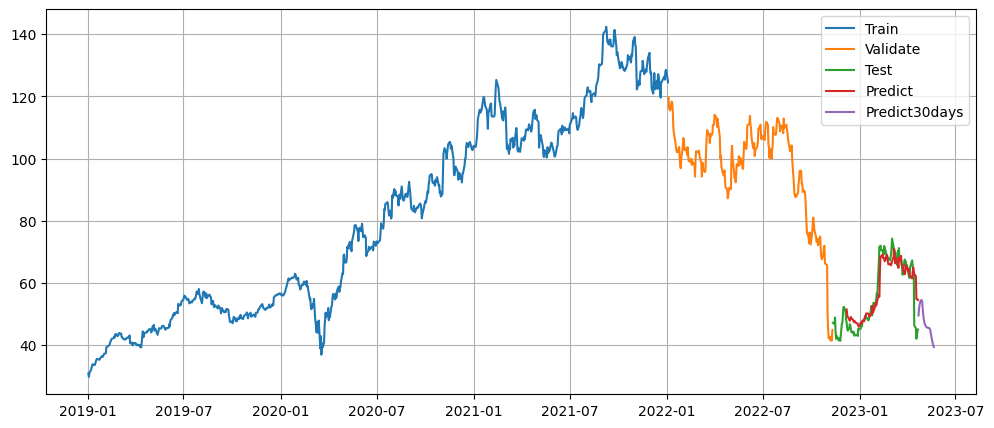

In [ ]:
plt.figure(figsize=(12, 5))

plt.plot(df.index[:train_size], scaler.inverse_transform(train_data))

plt.plot(df.index[train_size : train_size + val_size], scaler.inverse_transform(val_data))

plt.plot(df.index[train_size + val_size : ], scaler.inverse_transform(test_data))

plt.plot(df.index[train_size + val_size + best_window_size + 1: ], scaler.inverse_transform(best_y_pred))

plt.plot(index_next_30_days, y_next_30_days)

plt.legend(['Train', 'Validate', 'Test', 'Predict', 'Predict30days'])

plt.grid()
plt.title(f"Catalent Closing Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_30_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('TCAN_712_CTLT.png')
plt.show()